In [3]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
import pandas as pd
import pydotplus
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
meta_data_1 = pd.read_excel("D:\新传数据挖掘比赛\Code\Contest\data_minig_contest_new_media\data\combine_data_v2.xlsx")
meta_data = pd.read_excel("D:\新传数据挖掘比赛\Code\Contest\data_minig_contest_new_media\data\combine_data_v3_无序号.xlsx")

y_m_data = pd.read_excel("D:\新传数据挖掘比赛\Code\Contest\data_minig_contest_new_media\data\heat_events.xlsx")
y_data = y_m_data["热度"]

y_data_v2= meta_data_1["序号"]

In [38]:
print(meta_data.shape)
print(y_data.shape)
assert y_data.shape[0]==meta_data.shape[0]

(3920, 90)
(3920,)


In [16]:
meta_data

,时间衰减系数,点赞-mean,点赞-max,点赞-var,点赞-sum,转发-mean,转发-max,转发-var,转发-sum,评论-mean,...,甘肃,福建,西藏,贵州,辽宁,重庆,陕西,青海,香港,黑龙江
0,1.410959,0.000000,0.0,0.000000,0.0,0.057000,51.0,2.608359,57.0,0.047000,...,10.0,35.0,1.0,13.0,37.0,15.0,21.0,2.0,3.0,25.0
1,1.115068,0.000000,0.0,0.000000,0.0,0.021000,10.0,0.114674,21.0,0.089000,...,16.0,38.0,0.0,15.0,28.0,19.0,24.0,2.0,1.0,23.0
2,1.479452,0.000000,0.0,0.000000,0.0,0.104000,48.0,2.866050,104.0,0.115000,...,10.0,24.0,1.0,5.0,30.0,13.0,33.0,0.0,3.0,10.0
3,1.479452,0.000000,0.0,0.000000,0.0,0.057000,19.0,0.586337,57.0,0.209000,...,17.0,22.0,1.0,6.0,39.0,14.0,41.0,0.0,4.0,28.0
4,1.479452,0.000000,0.0,0.000000,0.0,0.008000,2.0,0.013950,8.0,0.791000,...,9.0,67.0,0.0,15.0,39.0,18.0,18.0,3.0,5.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3915,0.778082,0.000000,0.0,0.000000,0.0,0.026316,3.0,0.060978,6.0,0.429825,...,2.0,9.0,0.0,2.0,9.0,3.0,5.0,0.0,2.0,2.0
3916,0.758904,0.000000,0.0,0.000000,0.0,0.038760,3.0,0.100048,5.0,0.054264,...,1.0,2.0,0.0,5.0,2.0,0.0,3.0,0.0,0.0,0.0
3917,0.616438,0.000000,0.0,0.000000,0.0,0.025424,2.0,0.042083,3.0,0.398305,...,3.0,0.0,0.0,1.0,4.0,1.0,7.0,0.0,0.0,5.0
3918,0.646575,0.200000,2.0,0.400000,2.0,0.000000,0.0,0.000000,0.0,0.100000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
meta_data[meta_data.index==0]

,时间衰减系数,点赞-mean,点赞-max,点赞-var,点赞-sum,转发-mean,转发-max,转发-var,转发-sum,评论-mean,...,甘肃,福建,西藏,贵州,辽宁,重庆,陕西,青海,香港,黑龙江
0,1.410959,0.0,0.0,0.0,0.0,0.057,51.0,2.608359,57.0,0.047,...,10.0,35.0,1.0,13.0,37.0,15.0,21.0,2.0,3.0,25.0


In [6]:

def remove_invalid_rows(x_data):
    # 复制输入数据以保留原始数据不变
    x_data_process = x_data.copy()
    
    # 找到连续为空值或NAN的行
    is_invalid_row = x_data_process.isnull().any(axis=1)
    is_invalid_row |= x_data_process.isna().any(axis=1)
    # print("空无效值值列：",np.where(is_invalid_row[0]))
    # 找到连续13列值为0的行   注意：存在转发点赞评论为零的经过实验发现是12列最多，最后得到结果与人眼观测结果一致，得到所有去除后的数据  
    is_invalid_row |= (x_data_process == 0).astype(int).rolling(13, axis=1).sum().eq(13).any(axis=1)
    # 获取需要删除的行的索引
    invalid_row_indices = np.where(is_invalid_row)[0]
    
    # 删除无效行
    x_data_process.drop(x_data_process.index[invalid_row_indices], inplace=True)
    
    # 返回处理后的数据和删除的行索引
    return x_data_process, invalid_row_indices

# 使用示例
x_data_process, removed_indices = remove_invalid_rows(meta_data)

print("删除的行索引：", removed_indices)
print("处理后的数据：")
print(x_data_process)
print("removed_indices:",removed_indices)

删除的行索引： [  21   30   58   75   94   96   98  101  103  113  122  126  133  153
  157  164  167  180  181  194  195  208  211  216  236  250  291  298
  341  348  358  400  404  430  481  484  487  626  628  644  675  726
  771  792  823  840  895  922  974  979 1014 1097 1116 1286 1292 1347
 1471 1539 1547 1572 1573 1626 1628 1697 1721 1792 1825 1843 1880 1934
 2005 2073 2101 2249 2261 2392 2407 2423 2511 2733 2752 2756 2841 2843
 2864 2974 2987 3064 3077 3200 3378 3466 3577 3580 3582 3595 3651 3679
 3692 3710 3803 3808 3815 3835 3837 3843 3908 3918]
处理后的数据：
        时间衰减系数   点赞-mean  点赞-max    点赞-var  点赞-sum   转发-mean  转发-max  \
0     1.410959  0.000000     0.0  0.000000     0.0  0.057000    51.0   
1     1.115068  0.000000     0.0  0.000000     0.0  0.021000    10.0   
2     1.479452  0.000000     0.0  0.000000     0.0  0.104000    48.0   
3     1.479452  0.000000     0.0  0.000000     0.0  0.057000    19.0   
4     1.479452  0.000000     0.0  0.000000     0.0  0.008000     2.0   
...

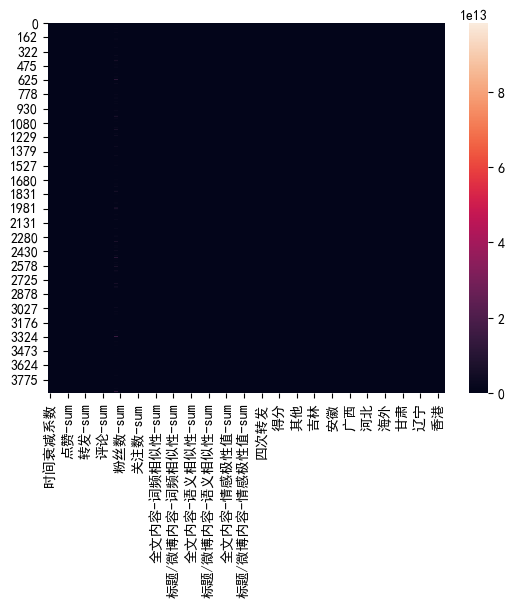

In [42]:
# 热度图 
plt.figure()
sns.heatmap(x_data_process)
plt.savefig('./data/seaborn_heatmap_metadata_list.png')
plt.show()

In [7]:
# 注意此处行号与excel中显示的行号数字减2
y_data_clean = y_data.drop(y_data.index[removed_indices]) 
y_data_clean_v2 = y_data_v2.drop(y_data_v2.index[removed_indices]) 

In [44]:
# check data shape
assert y_data_clean.shape[0]==x_data_process.shape[0]
assert y_data.shape[0]==meta_data.shape[0]

### GDBT Implement

In [45]:
# 1
X_train, X_test, y_train, y_test = train_test_split(x_data_process, y_data_clean, test_size=0.2, random_state=1)

In [8]:
# 2
X_train, X_test, y_train, y_test = train_test_split(x_data_process, y_data_clean_v2, test_size=0.2, random_state=1)

In [47]:
# X_train = X_train.drop("序号",axis=1)
# X_test = X_test.drop("序号",axis=1)

In [9]:
import joblib
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# 创建GradientBoostingRegressor模型
model = GradientBoostingRegressor()

# 定义参数搜索空间
# Best parameters {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
param_grid = {
    'n_estimators': [200, 400, 500],
    'learning_rate': [0.01,0.001],
    'max_depth': [3, 4, 5]
}

# 创建GridSearchCV对象
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
# X_train.drop("序号",axis=1)
# 拟合训练数据
grid_search.fit(X_train, y_train)

# 输出最佳参数组合
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# 保存最佳模型
joblib.dump(grid_search.best_estimator_, './models/best_model_7_15.pkl')

# 加载最佳模型
loaded_model = joblib.load('./models/best_model_7_15.pkl')


# 使用加载的模型进行预测
y_pred = loaded_model.predict(X_test)

# 计算均方误差
mse = mean_squared_error(y_test, y_pred)
print("Mean squared error:", mse)

Best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}
Mean squared error: 417052.3952077502


In [10]:
print(grid_search.best_score_)

0.6637238618701622


In [11]:
acc_train = grid_search.score(X_train, y_train)
acc_test = grid_search.score(X_test, y_test)
print("train accuracy:",acc_train)
print("test accuracy:",acc_test)

train accuracy: 0.84384421459413
test accuracy: 0.6902741976628526


In [52]:
# X_train.drop("序号",axis=1)

时间衰减系数     0.040365
点赞-mean    0.001293
点赞-max     0.001090
点赞-var     0.002238
点赞-sum     0.002461
             ...   
重庆         0.000924
陕西         0.001027
青海         0.000734
香港         0.001271
黑龙江        0.000460
Length: 90, dtype: float64
上海                    0.001326
江西                    0.001400
广东                    0.001421
河北                    0.001476
评论-var                0.001485
粉丝数-mean              0.001608
评论-max                0.001671
归1化                   0.001935
点赞-var                0.002238
关注数-var               0.002392
点赞-sum                0.002461
全文内容-情感极性值-max        0.002526
标题/微博内容-语义相似性-var     0.002726
评论-mean               0.002859
全文内容-语义相似性-sum        0.003758
全文内容-语义相似性-var        0.003856
粉丝数-sum               0.004230
标题/微博内容-语义相似性-sum     0.004230
全文内容-情感极性值-mean       0.004465
甘肃                    0.005006
全文内容-词频相似性-var        0.005088
标题/微博内容-语义相似性-mean    0.005885
贵州                    0.006439
其他                    0.008140
云南       

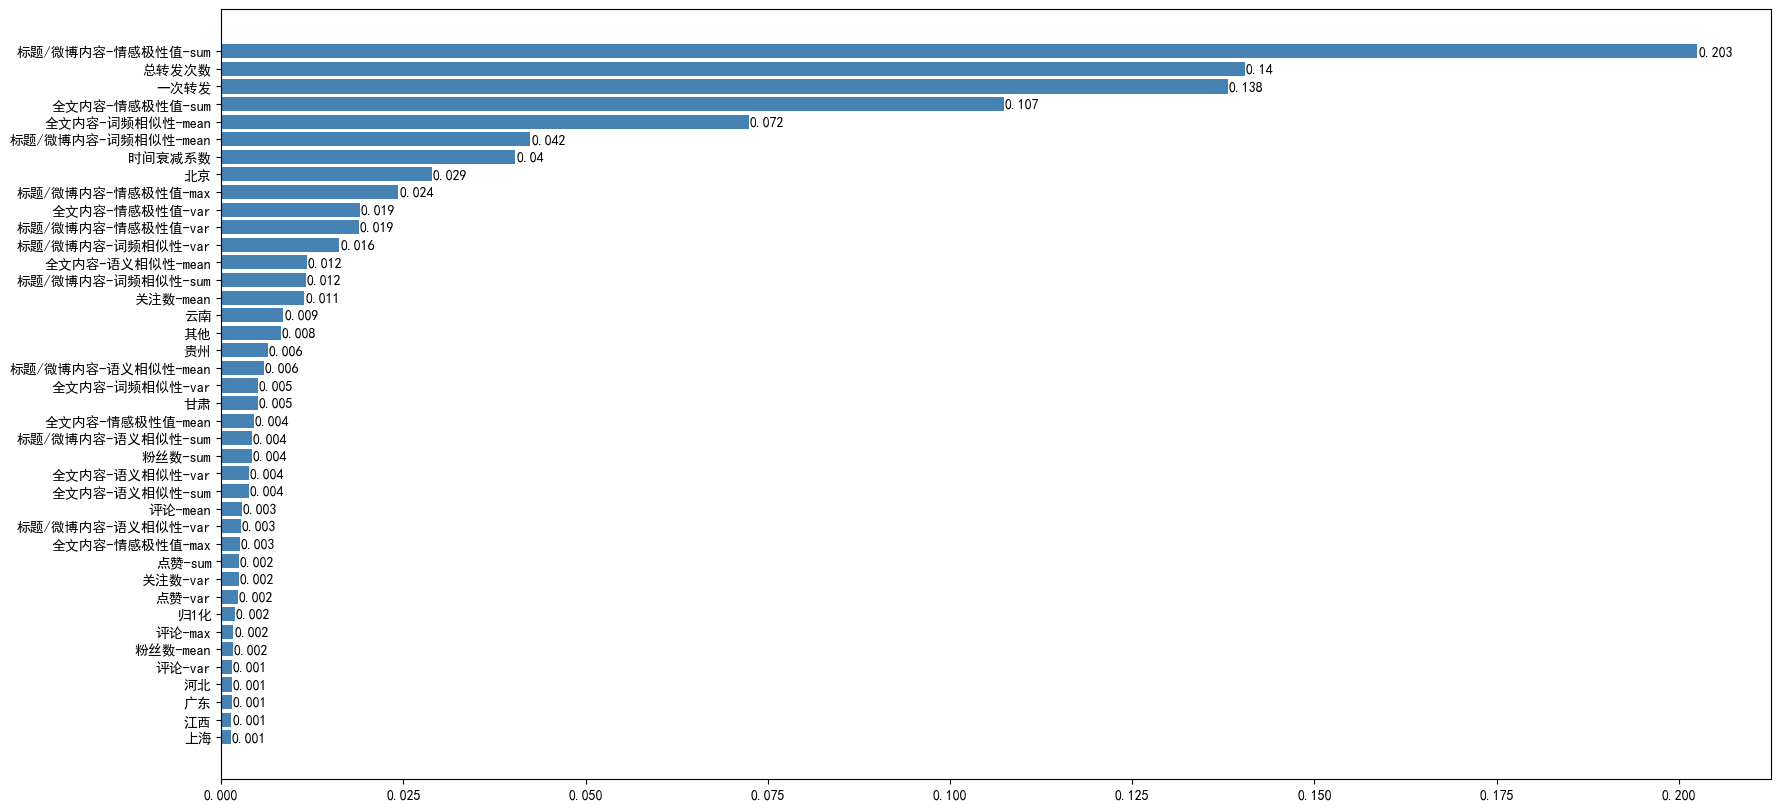

In [14]:
# GDBT特征重要性可视化

# 中文显示
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']


model = GradientBoostingRegressor()
params = {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
model.fit(X_train,y_train)



importance = model.feature_importances_
Impt_Series = pd.Series(importance, index = X_train.columns)
print(Impt_Series)



# Impt_Series.sort_values(ascending = True).plot('barh')
Impt_Series = Impt_Series.sort_values(ascending = True)
Impt_Series = Impt_Series[50:]
print(Impt_Series)
print(list(Impt_Series.index))
Y = list(Impt_Series.index)
# 绘制条形图
plt.figure(figsize=(20,10)) 
plt.barh(range(len(Y)), # 指定条形图y轴的刻度值
        Impt_Series.values, # 指定条形图x轴的数值
        tick_label = Y, # 指定条形图y轴的刻度标签
        color = 'steelblue', # 指定条形图的填充色
       )

print(Impt_Series.values)
# print()
for y,x in enumerate(Impt_Series.values):
    plt.text(x+0.0001,y,'%s' %round(x,3),va='center')

plt.savefig("./data/GDBT_feature_importance.jpg")    
plt.show()


C:\Users\OMEN\AppData\Local\Temp\ipykernel_20852\3534235634.py:23: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('./data/Residual_Plot_all_data.jpg')
c:\Users\OMEN\miniconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


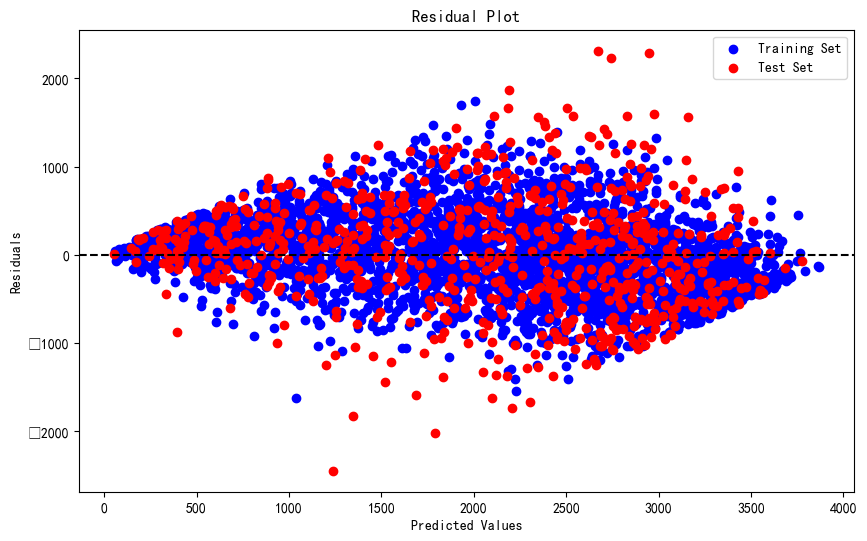

In [15]:
# 中文
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']

# 在训练集和测试集上进行预测
y_train_pred = loaded_model.predict(X_train)
y_test_pred = loaded_model.predict(X_test)


# 计算预测与真实值之间的残差
train_residuals = y_train_pred - y_train
test_residuals = y_test_pred - y_test

# 绘制残差图
plt.figure(figsize=(10, 6))
plt.scatter(y_train_pred, train_residuals, c='blue', label='Training Set')
plt.scatter(y_test_pred, test_residuals, c='red', label='Test Set')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend()
plt.savefig('./data/Residual_Plot_all_data.jpg')
plt.show()